In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
from scipy.special import entr
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
dataset_path_1st = './nasa/1st_test/1st_test'
dataset_path_2nd = './nasa/2nd_test/2nd_test'
dataset_path_3rd = './nasa/3rd_test/4th_test/txt'

In [3]:
len(os.listdir(dataset_path_3rd))

6324

In [17]:
# Test for the first file
dataset = pd.read_csv('./nasa/2nd_test/2nd_test/2004.02.12.10.32.39', sep='\t')
dataset.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
dataset.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,-0.042,-0.073,-0.007,-0.105
1,0.015,0.000,0.007,0.000
2,-0.051,0.020,-0.002,0.100
3,-0.107,0.010,0.127,0.054
4,-0.078,-0.212,0.042,-0.044


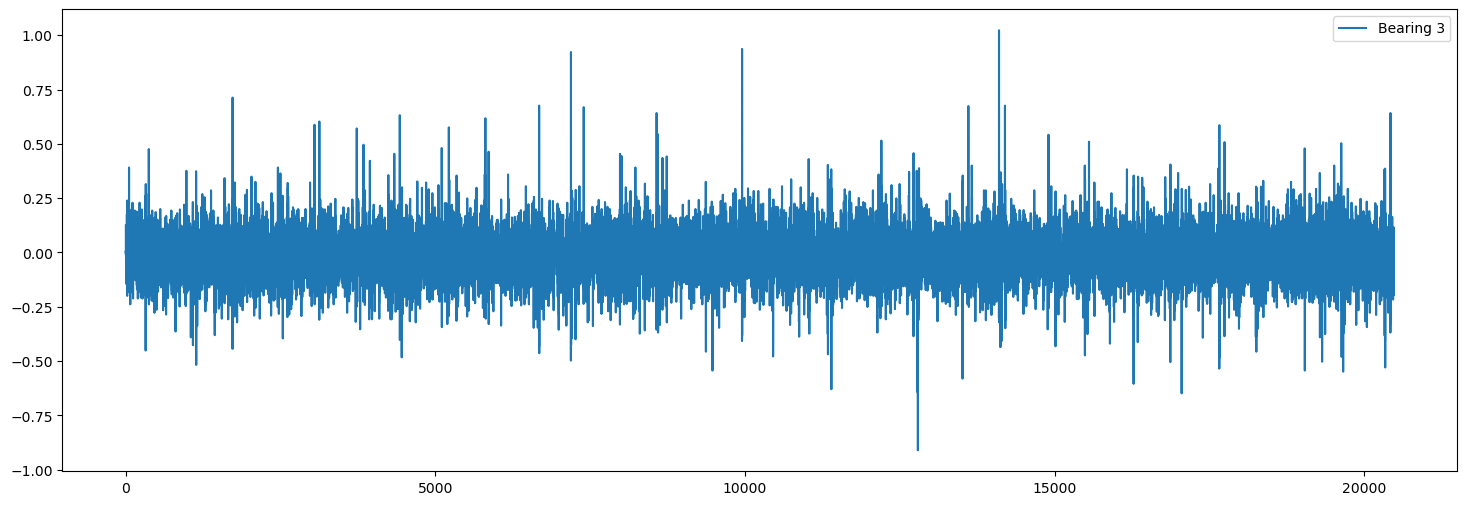

In [18]:
dataset[['Bearing 3']].plot(figsize=(18,6));

In [19]:
# old extract function
def merge_data(dataset_path, id_set=None):
    data = pd.DataFrame()
    for filename in os.listdir(dataset_path):
        dataset=pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        dataset_mean_abs = np.array(dataset.abs().mean()) # 절대값 평균
        if id_set == 1:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,8))
        else:
            dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
        dataset_mean_abs.index = [filename]
        data = data.append(dataset_mean_abs)
    
    if id_set == 1:
        data.columns = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b']
    else:
        data.columns = ['B1','B2','B3','B4']
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [20]:
def calculate_rms(df):
    result = []
    for col in df:
        r = np.sqrt((df[col]**2).sum() / len(df[col]))
        result.append(r)
    return result

# extract peak-to-peak features
def calculate_p2p(df):
    return np.array(df.max().abs() + df.min().abs())

# extract shannon entropy (cut signals to 500 bins)
def calculate_entropy(df):
    entropy = []
    for col in df:
        entropy.append(scipy.stats.entropy(pd.cut(df[col], 500).value_counts()))
    return np.array(entropy)

def time_features(dataset_path, id_set=None):
    time_features = ['mean','std','skew','rms','p2p'] # ,'max','kurtosis','entropy']
    cols1 = ['B1_a','B1_b','B2_a','B2_b','B3_a','B3_b','B4_a','B4_b']
    cols2 = ['B1','B2','B3','B4']
    
    # initialize
    if id_set == 1:
        columns = [c+'_'+tf for c in cols1 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    else:
        columns = [c+'_'+tf for c in cols2 for tf in time_features]
        data = pd.DataFrame(columns=columns)
    
    for filename in os.listdir(dataset_path):
        # read dataset
        raw_data = pd.read_csv(os.path.join(dataset_path, filename), sep='\t')
        
        # time features
        mean_abs = np.array(raw_data.abs().mean()) #
        std = np.array(raw_data.std())             #
        skew = np.array(raw_data.skew())           #
        # kurtosis = np.array(raw_data.kurtosis())
        # entropy = calculate_entropy(raw_data)
        rms = np.array(calculate_rms(raw_data))    #
        # max_abs = np.array(raw_data.abs().max())
        p2p = calculate_p2p(raw_data)              #
        
        if id_set == 1:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,8), columns=[c+'_mean' for c in cols1])
            std = pd.DataFrame(std.reshape(1,8), columns=[c+'_std' for c in cols1])
            skew = pd.DataFrame(skew.reshape(1,8), columns=[c+'_skew' for c in cols1])
            # kurtosis = pd.DataFrame(kurtosis.reshape(1,8), columns=[c+'_kurtosis' for c in cols1])
            # entropy = pd.DataFrame(entropy.reshape(1,8), columns=[c+'_entropy' for c in cols1])
            rms = pd.DataFrame(rms.reshape(1,8), columns=[c+'_rms' for c in cols1])
            # max_abs = pd.DataFrame(max_abs.reshape(1,8), columns=[c+'_max' for c in cols1])
            p2p = pd.DataFrame(p2p.reshape(1,8), columns=[c+'_p2p' for c in cols1])
        else:
            mean_abs = pd.DataFrame(mean_abs.reshape(1,4), columns=[c+'_mean' for c in cols2])
            std = pd.DataFrame(std.reshape(1,4), columns=[c+'_std' for c in cols2])
            skew = pd.DataFrame(skew.reshape(1,4), columns=[c+'_skew' for c in cols2])
            # kurtosis = pd.DataFrame(kurtosis.reshape(1,4), columns=[c+'_kurtosis' for c in cols2])
            # entropy = pd.DataFrame(entropy.reshape(1,4), columns=[c+'_entropy' for c in cols2])
            rms = pd.DataFrame(rms.reshape(1,4), columns=[c+'_rms' for c in cols2])
            # max_abs = pd.DataFrame(max_abs.reshape(1,4), columns=[c+'_max' for c in cols2])
            p2p = pd.DataFrame(p2p.reshape(1,4), columns=[c+'_p2p' for c in cols2])
            
        mean_abs.index = [filename]
        std.index = [filename]
        skew.index = [filename]
        # kurtosis.index = [filename]
        # entropy.index = [filename]
        rms.index = [filename]
        # max_abs.index = [filename]
        p2p.index = [filename]
        
        # concat
        merge = pd.concat([mean_abs, std, skew, rms, p2p], axis=1) #, max_abs, kurtosis, entropy], axis=1)
        data = data.append(merge)
        
    if id_set == 1:
        cols = [c+'_'+tf for c in cols1 for tf in time_features]
        data = data[cols]
    else:
        cols = [c+'_'+tf for c in cols2 for tf in time_features]
        data = data[cols]
        
    data.index = pd.to_datetime(data.index, format='%Y.%m.%d.%H.%M.%S')
    data = data.sort_index()
    return data

In [21]:
%%time
set1 = time_features(dataset_path_1st, id_set=1)
set2 = time_features(dataset_path_2nd, id_set=2)
set3 = time_features(dataset_path_3rd, id_set=3)

C:\Users\dk866\AppData\Local\Temp\ipykernel_13264\891298212.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(merge)
C:\Users\dk866\AppData\Local\Temp\ipykernel_13264\891298212.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(merge)
C:\Users\dk866\AppData\Local\Temp\ipykernel_13264\891298212.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(merge)
C:\Users\dk866\AppData\Local\Temp\ipykernel_13264\891298212.py:76: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(merge)
C:\Users\dk866\AppData\Local\Temp\ipykernel_13264\891298212.py:76: FutureWarning: The fr

Wall time: 1min 44s


In [22]:
set2.isnull().sum().sum()

0

In [23]:
set1.to_csv('set1_timefeatures.csv')
set2.to_csv('set2_timefeatures.csv')
set3.to_csv('set3_timefeatures.csv')

In [25]:
set2 = pd.read_csv('./set2_timefeatures.csv')
set2['B1_skew']


0      0.083929
1      0.052054
2      0.032869
3      0.041523
4      0.028134
         ...   
979   -0.510599
980   -0.325334
981   -0.377115
982    0.579749
983    0.316970
Name: B1_skew, Length: 984, dtype: float64